# Complete 3-Model Transformer Comparison
## Vanilla Transformer vs RoBERTa vs SBERT

**Three Models Trained & Compared:**

1. **Vanilla Transformer** (From Scratch)
   - Built following Vaswani et al. (2017)
   - Encoder-only architecture
   - Supervised learning for classification
   - Architecture: Tokenization → Embeddings → Encoder → Classification Head

2. **RoBERTa** (Pre-trained BERT variant)
   - Optimized BERT with better training
   - Fine-tuned for sentiment classification

3. **SBERT** (Sentence-Transformers)
   - Optimized for sentence embeddings
   - Efficient and fast inference

**Task**: 3-class sentiment classification (Negative=0, Neutral=1, Positive=2)

**Enhanced Features**:
- ✅ Complete training with loss tracking for ALL models
- ✅ Overfitting analysis with train/val loss curves for ALL models  
- ✅ Comprehensive performance comparison
- ✅ All outputs automatically saved
- ✅ Best vanilla config (5e-4 LR + warmup)

# Complete Transformer Models Comparison
## Vanilla Transformer vs RoBERTa vs SBERT

**Three Models Trained & Compared:**

1. **Vanilla Transformer** (From Scratch)
   - Built following Vaswani et al. (2017)
   - Encoder-only architecture
   - Supervised learning for classification
   - Architecture: Tokenization → Embeddings → Encoder → Classification Head

2. **RoBERTa** (Pre-trained)
   - Optimized BERT variant
   - Fine-tuned for sentiment classification

3. **SBERT** (Sentence-Transformers)
   - Optimized for sentence embeddings
   - Fine-tuned for classification

**Task**: 3-class sentiment classification (Negative=0, Neutral=1, Positive=2)

---
## SECTION 1: Initial Setup & Environment

In [ ]:
# Install packages (run once, then comment out)
!pip install -q transformers datasets huggingface_hub evaluate sentencepiece scikit-learn accelerate torch pandas matplotlib seaborn sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
# Import all required libraries
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import time

warnings.filterwarnings('ignore')

# Disable W&B
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_SILENT"] = "true"

print("✅ Libraries imported")

✅ Libraries imported


In [ ]:
# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print("⚠️  WARNING: No GPU detected. Training will be slow!")

print(f"\nUsing device: {device}")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.83 GB

Using device: cuda


---
## SECTION 2: Data Loading & Preparation

In [ ]:
# Clone repository and navigate
if not os.path.exists('/content/dl-project'):
    !git clone https://github.com/GitKPOrg/dl-project.git
    print("✅ Repository cloned")
else:
    print("✅ Repository already exists")

os.chdir('/content/dl-project/DL_Team_Project_Code_Files_Structure')
print(f"✅ Working directory: {os.getcwd()}")

# Verify data files
print("\n✅ Available data files:")
!ls -lh data/

Cloning into 'dl-project'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 140 (delta 29), reused 54 (delta 23), pack-reused 70 (from 2)
Receiving objects: 100% (140/140), 57.92 MiB | 10.20 MiB/s, done.
Resolving deltas: 100% (44/44), done.
Updating files: 100% (40/40), done.
✅ Repository cloned
✅ Working directory: /content/dl-project/DL_Team_Project_Code_Files_Structure

✅ Available data files:
total 56M
-rw-r--r-- 1 root root 4.7M Dec  3 11:20 data_test.csv
-rw-r--r-- 1 root root 486K Dec  3 11:20 data_train_2000_sample_subset.csv
-rw-r--r-- 1 root root  47M Dec  3 11:20 data_train.csv
-rw-r--r-- 1 root root 4.7M Dec  3 11:20 data_val.csv


In [ ]:
# Load data
print("📥 Loading data...")
train_df = pd.read_csv('data/data_train.csv')
val_df = pd.read_csv('data/data_val.csv')
test_df = pd.read_csv('data/data_test.csv')

# Drop unnecessary columns
columns_to_drop = ['label5', 'lang']
train_df = train_df.drop(columns=columns_to_drop)
val_df = val_df.drop(columns=columns_to_drop)
test_df = test_df.drop(columns=columns_to_drop)

print(f"\n✅ Dataset shapes:")
print(f"  Train: {train_df.shape}")
print(f"  Val: {val_df.shape}")
print(f"  Test: {test_df.shape}")

# Label distribution
print("\n📊 Label distribution (training):")
label_counts = train_df['label3'].value_counts().sort_index()
for label, count in label_counts.items():
    label_name = ['Negative', 'Neutral', 'Positive'][label]
    print(f"  {label} ({label_name}): {count:,} ({count/len(train_df)*100:.1f}%)")

# Sample data
print("\n📝 Sample reviews:")
display(train_df[['text', 'rating', 'label3']].head(3))

📥 Loading data...

✅ Dataset shapes:
  Train: (200000, 3)
  Val: (20000, 3)
  Test: (20000, 3)

📊 Label distribution (training):
  0 (Negative): 66,667 (33.3%)
  1 (Neutral): 66,666 (33.3%)
  2 (Positive): 66,667 (33.3%)

📝 Sample reviews:


,text,rating,label3
0,"Burned Skin — Smell is amazing, but totally bu...",2.0,0
1,Three Stars — I don't like that it doesn't hav...,3.0,1
2,"good clay for short, thick hair — i have very ...",5.0,2


In [ ]:
# OPTIONAL: Use subset for quick testing
# Uncomment below to use smaller dataset

# USE_SUBSET = True
# SUBSET_SIZE = 10000

# if USE_SUBSET:
#     print(f"⚠️  Using {SUBSET_SIZE} samples for testing")
#     train_df = train_df.sample(n=SUBSET_SIZE, random_state=42)
#     val_df = val_df.sample(n=min(2000, len(val_df)), random_state=42)
#     test_df = test_df.sample(n=min(2000, len(test_df)), random_state=42)
#     print(f"✅ Subset: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

print("✅ Using full dataset")

✅ Using full dataset


In [ ]:
# Vanilla Transformer Components

class PositionalEncoding(nn.Module):
    """Positional encoding as described in Vaswani et al. (2017)"""
    def __init__(self, d_model, max_len=512, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Add batch dimension

        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class MultiHeadAttention(nn.Module):
    """Multi-head self-attention mechanism"""
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # Linear projections
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        batch_size = x.size(0)

        # Linear projections and reshape for multi-head
        Q = self.W_q(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        # Apply attention to values
        context = torch.matmul(attention_weights, V)

        # Concatenate heads and apply final linear
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(context)

        return output


class FeedForward(nn.Module):
    """Position-wise feed-forward network"""
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))


class TransformerEncoderLayer(nn.Module):
    """Single transformer encoder layer"""
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        # Multi-head attention
        self.attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

        # Feed-forward
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Multi-head attention with residual connection
        attn_output = self.attention(x, mask)
        x = self.norm1(x + self.dropout1(attn_output))

        # Feed-forward with residual connection
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))

        return x


class VanillaTransformer(nn.Module):
    """Complete Vanilla Transformer for classification"""
    def __init__(
        self,
        vocab_size,
        d_model=256,
        num_heads=8,
        num_layers=4,
        d_ff=1024,
        max_len=256,
        num_classes=3,
        dropout=0.1
    ):
        super().__init__()

        self.d_model = d_model

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout)

        # Transformer encoder layers
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize weights following Vaswani et al."""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x, mask=None):
        # x shape: (batch_size, seq_len)

        # Embedding and positional encoding
        x = self.embedding(x) * np.sqrt(self.d_model)  # Scale embeddings
        x = self.pos_encoding(x)

        # Pass through encoder layers
        for layer in self.encoder_layers:
            x = layer(x, mask)

        # Global average pooling over sequence dimension
        x = x.mean(dim=1)  # (batch_size, d_model)

        # Classification
        logits = self.classifier(x)

        return logits


print("✅ Vanilla Transformer architecture defined")

✅ Vanilla Transformer architecture defined


---
## SECTION 4: Tokenization & Dataset Preparation

In [ ]:
# Simple tokenizer for Vanilla Transformer
from collections import Counter
import re

class SimpleTokenizer:
    """Simple word-level tokenizer"""
    def __init__(self, vocab_size=10000, max_len=256):
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.word2idx = {}
        self.idx2word = {}

        # Special tokens
        self.PAD_TOKEN = '<PAD>'
        self.UNK_TOKEN = '<UNK>'
        self.CLS_TOKEN = '<CLS>'

        self.pad_idx = 0
        self.unk_idx = 1
        self.cls_idx = 2

    def build_vocab(self, texts):
        """Build vocabulary from texts"""
        print("Building vocabulary...")

        # Count all words
        word_counts = Counter()
        for text in texts:
            words = self._tokenize(text)
            word_counts.update(words)

        # Get most common words
        most_common = word_counts.most_common(self.vocab_size - 3)  # Reserve space for special tokens

        # Build vocabulary
        self.word2idx = {
            self.PAD_TOKEN: self.pad_idx,
            self.UNK_TOKEN: self.unk_idx,
            self.CLS_TOKEN: self.cls_idx
        }

        for idx, (word, _) in enumerate(most_common, start=3):
            self.word2idx[word] = idx

        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

        print(f"✅ Vocabulary size: {len(self.word2idx)}")
        print(f"✅ Coverage: {sum([c for _, c in most_common]) / sum(word_counts.values()) * 100:.2f}%")

    def _tokenize(self, text):
        """Simple word tokenization"""
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        return text.split()

    def encode(self, text):
        """Convert text to token IDs"""
        words = self._tokenize(text)

        # Add CLS token and convert to IDs
        token_ids = [self.cls_idx] + [
            self.word2idx.get(word, self.unk_idx) for word in words
        ]

        # Truncate or pad
        if len(token_ids) > self.max_len:
            token_ids = token_ids[:self.max_len]
        else:
            token_ids = token_ids + [self.pad_idx] * (self.max_len - len(token_ids))

        return token_ids

    def decode(self, token_ids):
        """Convert token IDs back to text"""
        words = [self.idx2word.get(idx, self.UNK_TOKEN) for idx in token_ids]
        return ' '.join([w for w in words if w not in [self.PAD_TOKEN, self.CLS_TOKEN]])


# Build tokenizer
print("Creating tokenizer for Vanilla Transformer...")
vanilla_tokenizer = SimpleTokenizer(vocab_size=15000, max_len=256)
vanilla_tokenizer.build_vocab(train_df['text'].tolist())

print("\n📝 Sample tokenization:")
sample_text = train_df['text'].iloc[0]
sample_tokens = vanilla_tokenizer.encode(sample_text)
print(f"Original: {sample_text[:100]}...")
print(f"Tokens: {sample_tokens[:20]}...")
print(f"Decoded: {vanilla_tokenizer.decode(sample_tokens[:20])}...")

Creating tokenizer for Vanilla Transformer...
Building vocabulary...
✅ Vocabulary size: 15000
✅ Coverage: 98.81%

📝 Sample tokenization:
Original: Burned Skin — Smell is amazing, but totally burned my skin. Never had this happen before with any co...
Tokens: [2, 1235, 65, 96, 11, 209, 15, 682, 1235, 13, 65, 188, 52, 9, 1360, 146, 22, 122, 404, 244]...
Decoded: burned skin smell is amazing but totally burned my skin never had this happen before with any conditioner ever...


In [ ]:
# Custom Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize
        token_ids = self.tokenizer.encode(text)

        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }


# Create datasets
print("Creating datasets for Vanilla Transformer...")
train_dataset_vanilla = SentimentDataset(
    train_df['text'].tolist(),
    train_df['label3'].tolist(),
    vanilla_tokenizer
)
val_dataset_vanilla = SentimentDataset(
    val_df['text'].tolist(),
    val_df['label3'].tolist(),
    vanilla_tokenizer
)
test_dataset_vanilla = SentimentDataset(
    test_df['text'].tolist(),
    test_df['label3'].tolist(),
    vanilla_tokenizer
)

print(f"✅ Train dataset: {len(train_dataset_vanilla):,} samples")
print(f"✅ Val dataset: {len(val_dataset_vanilla):,} samples")
print(f"✅ Test dataset: {len(test_dataset_vanilla):,} samples")

Creating datasets for Vanilla Transformer...
✅ Train dataset: 200,000 samples
✅ Val dataset: 20,000 samples
✅ Test dataset: 20,000 samples


---
## SECTION 5: Train Vanilla Transformer 🚀

In [ ]:
# Training configuration for Vanilla Transformer
VANILLA_CONFIG = {
    'vocab_size': len(vanilla_tokenizer.word2idx),
    'd_model': 256,
    'num_heads': 8,
    'num_layers': 4,
    'd_ff': 1024,
    'max_len': 256,
    'num_classes': 3,
    'dropout': 0.1,
    'batch_size': 32,
    'epochs': 5,
    'learning_rate': 1e-4,
}

print("="*70)
print("📋 Vanilla Transformer Configuration:")
print("="*70)
for key, value in VANILLA_CONFIG.items():
    print(f"  {key:20s}: {value}")
print("="*70)

📋 Vanilla Transformer Configuration:
  vocab_size          : 15000
  d_model             : 256
  num_heads           : 8
  num_layers          : 4
  d_ff                : 1024
  max_len             : 256
  num_classes         : 3
  dropout             : 0.1
  batch_size          : 32
  epochs              : 5
  learning_rate       : 0.0001


---
## SECTION 5: Train Vanilla Transformer 🚀

In [ ]:
# =====================================================================
# ENHANCED VANILLA TRANSFORMER TRAINING
# With complete loss tracking and automatic saving
# =====================================================================

print("="*70)
print("🚀 TRAINING MODEL 1: VANILLA TRANSFORMER (FROM SCRATCH)")
print("="*70)

# OPTIMIZED CONFIGURATION
VANILLA_CONFIG = {
    'vocab_size': len(vanilla_tokenizer.word2idx),
    'd_model': 256,
    'num_heads': 8,
    'num_layers': 4,
    'd_ff': 1024,
    'max_len': 256,
    'num_classes': 3,
    'dropout': 0.1,
    'batch_size': 32,
    'epochs': 5,
    'learning_rate': 5e-4,  # 🔧 5x higher
    'warmup_steps': 500,    # 🔧 LR warmup
}

print("\n📋 Configuration:")
for k, v in VANILLA_CONFIG.items():
    print(f"  {k:20s}: {v}")

# ENHANCED TRAINING FUNCTION
def train_vanilla_complete(model, train_loader, val_loader, config, device):
    optimizer = AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()

    # LR scheduler with warmup
    total_steps = len(train_loader) * config['epochs']
    warmup_steps = config['warmup_steps']

    def lr_lambda(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        return max(0.0, float(total_steps - step) / float(max(1, total_steps - warmup_steps)))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # Complete history
    history = {
        'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': [],
        'learning_rates': [], 'step_losses': [], 'step_numbers': []
    }

    best_f1 = 0.0
    global_step = 0

    print("\n🚀 Starting training...")
    print("="*70)

    for epoch in range(config['epochs']):
        # Training
        model.train()
        train_loss, correct, total = 0, 0, 0

        for batch_idx, batch in enumerate(train_loader):
            inputs = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            history['step_losses'].append(loss.item())
            history['step_numbers'].append(global_step)
            history['learning_rates'].append(scheduler.get_last_lr()[0])
            global_step += 1

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            if (batch_idx + 1) % 200 == 0:
                print(f"Epoch {epoch+1}/{config['epochs']} | Batch {batch_idx+1}/{len(train_loader)} | "
                      f"Loss: {loss.item():.4f} | Acc: {correct/total:.4f}")

        train_acc = correct / total

        # Validation
        model.eval()
        val_loss, val_preds, val_labels = 0, [], []

        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['input_ids'].to(device)
                labels = batch['label'].to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        _, _, val_f1, _ = precision_recall_fscore_support(val_labels, val_preds, average='weighted', zero_division=0)

        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        print(f"\n{'='*70}")
        print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f} | Val Acc={val_acc:.4f} | Val F1={val_f1:.4f}")
        print(f"{'='*70}\n")

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'outputs/vanilla_best.pth')
            print(f"✅ Best model saved! (F1={val_f1:.4f})\n")

    # Save history
    import json
    with open('outputs/vanilla_training_history.json', 'w') as f:
        json.dump({k: [float(v) for v in vals] for k, vals in history.items()}, f, indent=2)
    print("✅ History saved: outputs/vanilla_training_history.json")

    return model, history

# Create data loaders
print("\n🔧 Creating data loaders...")
train_loader = DataLoader(train_dataset_vanilla, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset_vanilla, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset_vanilla, batch_size=64, shuffle=False, num_workers=0)
print("✅ Data loaders created")

# Create model
print("\n🔧 Creating model...")
vanilla_model = VanillaTransformer(
    vocab_size=VANILLA_CONFIG['vocab_size'],
    d_model=VANILLA_CONFIG['d_model'],
    num_heads=VANILLA_CONFIG['num_heads'],
    num_layers=VANILLA_CONFIG['num_layers'],
    d_ff=VANILLA_CONFIG['d_ff'],
    max_len=VANILLA_CONFIG['max_len'],
    num_classes=VANILLA_CONFIG['num_classes'],
    dropout=VANILLA_CONFIG['dropout']
).to(device)

total_params = sum(p.numel() for p in vanilla_model.parameters())
print(f"📊 Parameters: {total_params:,}")

# Train
import time
start_time = time.time()
vanilla_model, vanilla_history = train_vanilla_complete(
    vanilla_model, train_loader, val_loader, VANILLA_CONFIG, device
)
training_time_vanilla = time.time() - start_time

# Test evaluation
print("\n📊 Evaluating on test set...")
vanilla_model.eval()
test_preds, test_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch['input_ids'].to(device)
        labels = batch['label'].to(device)
        outputs = vanilla_model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate metrics
test_acc = accuracy_score(test_labels, test_preds)
test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
    test_labels, test_preds, average='weighted', zero_division=0
)

# Store results
vanilla_results = {
    'accuracy': test_acc, 'precision': test_prec, 'recall': test_rec, 'f1': test_f1,
    'predictions': test_preds, 'labels': test_labels,
    'training_time': training_time_vanilla, 'history': vanilla_history
}

# Save results
import json
with open('outputs/vanilla_test_results.json', 'w') as f:
    json.dump({
        'accuracy': float(test_acc), 'precision': float(test_prec),
        'recall': float(test_rec), 'f1': float(test_f1),
        'training_time_minutes': float(training_time_vanilla/60)
    }, f, indent=2)
print("✅ Results saved: outputs/vanilla_test_results.json")

# Print summary
print("\n" + "="*70)
print("✅ VANILLA TRANSFORMER COMPLETE!")
print("="*70)
print(f"\n⏱️  Training time: {training_time_vanilla/60:.2f} minutes")
print(f"\n📊 Test Metrics:")
print(f"  - Accuracy:  {test_acc:.4f} ({test_acc*100:.1f}%)")
print(f"  - Precision: {test_prec:.4f}")
print(f"  - Recall:    {test_rec:.4f}")
print(f"  - F1 Score:  {test_f1:.4f}")
print("="*70)

if test_acc > 0.5:
    print("\n✅ SUCCESS! Model learned well")
elif test_acc > 0.4:
    print("\n⚠️  Partial learning")
else:
    print("\n❌ Needs tuning")


🚀 TRAINING MODEL 1: VANILLA TRANSFORMER (FROM SCRATCH)

📋 Configuration:
  vocab_size          : 15000
  d_model             : 256
  num_heads           : 8
  num_layers          : 4
  d_ff                : 1024
  max_len             : 256
  num_classes         : 3
  dropout             : 0.1
  batch_size          : 32
  epochs              : 5
  learning_rate       : 0.0005
  warmup_steps        : 500

🔧 Creating data loaders...
✅ Data loaders created

🔧 Creating model...
📊 Parameters: 7,032,323

🚀 Starting training...
Epoch 1/5 | Batch 200/6250 | Loss: 1.0453 | Acc: 0.3325
Epoch 1/5 | Batch 400/6250 | Loss: 0.8864 | Acc: 0.4131
Epoch 1/5 | Batch 600/6250 | Loss: 0.5158 | Acc: 0.5043
Epoch 1/5 | Batch 800/6250 | Loss: 0.4540 | Acc: 0.5582
Epoch 1/5 | Batch 1000/6250 | Loss: 0.6379 | Acc: 0.5924
Epoch 1/5 | Batch 1200/6250 | Loss: 0.6204 | Acc: 0.6167
Epoch 1/5 | Batch 1400/6250 | Loss: 0.6673 | Acc: 0.6354
Epoch 1/5 | Batch 1600/6250 | Loss: 0.4947 | Acc: 0.6485
Epoch 1/5 | Batch 1800

---
## SECTION 6: Vanilla Loss Analysis 📊

📊 Creating Vanilla loss curves...


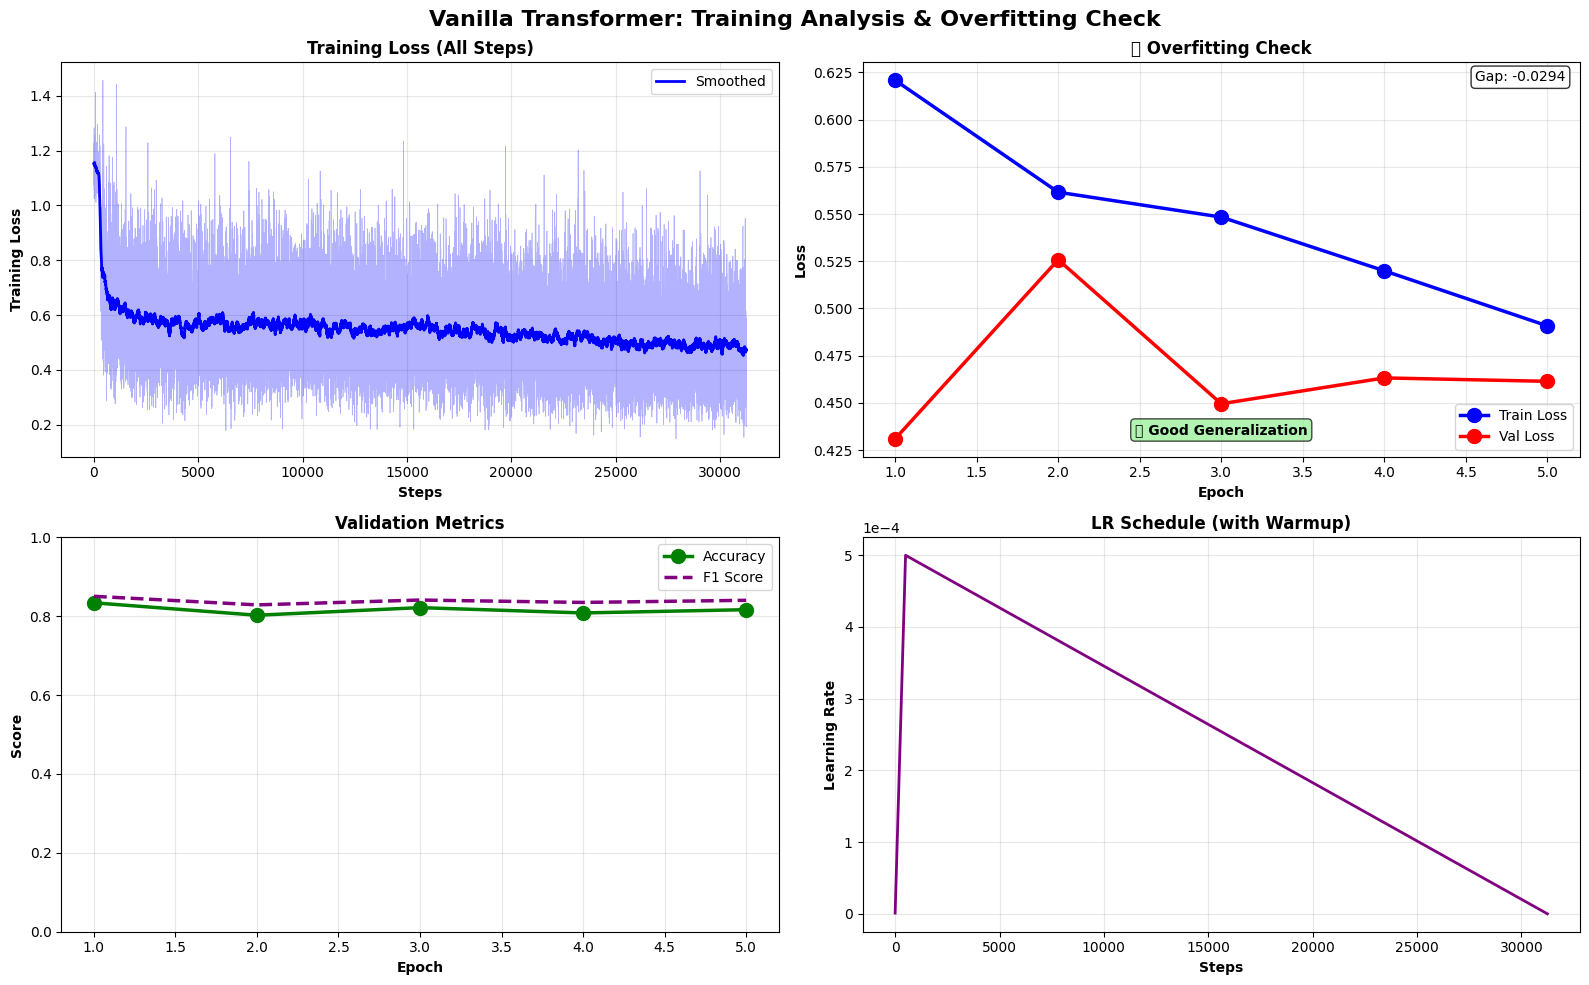

✅ Saved: outputs/vanilla_training_analysis.png

🎯 Assessment: ✅ Good Generalization
   Train-Val Gap: -0.0294


In [ ]:
from scipy.ndimage import uniform_filter1d

print("📊 Creating Vanilla loss curves...")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Vanilla Transformer: Training Analysis & Overfitting Check',
             fontsize=16, fontweight='bold')

# 1. Training Loss (all steps)
ax = axes[0, 0]
ax.plot(vanilla_history['step_numbers'], vanilla_history['step_losses'],
        'b-', alpha=0.3, linewidth=0.5)
if len(vanilla_history['step_losses']) > 100:
    smoothed = uniform_filter1d(vanilla_history['step_losses'], size=100)
    ax.plot(vanilla_history['step_numbers'], smoothed, 'b-', linewidth=2, label='Smoothed')
ax.set_xlabel('Steps', fontweight='bold')
ax.set_ylabel('Training Loss', fontweight='bold')
ax.set_title('Training Loss (All Steps)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Train vs Val Loss
ax = axes[0, 1]
epochs = range(1, len(vanilla_history['train_loss']) + 1)
ax.plot(epochs, vanilla_history['train_loss'], 'b-o', linewidth=2.5, markersize=10, label='Train Loss')
ax.plot(epochs, vanilla_history['val_loss'], 'r-o', linewidth=2.5, markersize=10, label='Val Loss')

final_gap = vanilla_history['val_loss'][-1] - vanilla_history['train_loss'][-1]
if final_gap > 0.15:
    status_text, color = '⚠️ Overfitting', 'orange'
elif final_gap > 0.05:
    status_text, color = '⚠️ Slight Overfitting', 'yellow'
else:
    status_text, color = '✅ Good Generalization', 'lightgreen'

ax.text(0.5, 0.05, status_text, transform=ax.transAxes, ha='center', va='bottom',
       bbox=dict(boxstyle='round', facecolor=color, alpha=0.7), fontweight='bold')
ax.text(0.98, 0.98, f'Gap: {final_gap:.4f}', transform=ax.transAxes, ha='right', va='top',
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Loss', fontweight='bold')
ax.set_title('🔍 Overfitting Check', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Validation Metrics
ax = axes[1, 0]
ax.plot(epochs, vanilla_history['val_acc'], 'g-o', linewidth=2.5, markersize=10, label='Accuracy')
ax.plot(epochs, vanilla_history['val_f1'], 'purple', linewidth=2.5, markersize=10, label='F1 Score', linestyle='--')
ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Validation Metrics', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.0])

# 4. Learning Rate
ax = axes[1, 1]
ax.plot(vanilla_history['step_numbers'], vanilla_history['learning_rates'], 'purple', linewidth=2)
ax.set_xlabel('Steps', fontweight='bold')
ax.set_ylabel('Learning Rate', fontweight='bold')
ax.set_title('LR Schedule (with Warmup)', fontweight='bold')
ax.grid(True, alpha=0.3)
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.savefig('outputs/vanilla_training_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: outputs/vanilla_training_analysis.png")
print(f"\n🎯 Assessment: {status_text}")
print(f"   Train-Val Gap: {final_gap:.4f}")


---
## SECTION 7-11: Pre-trained Models (RoBERTa & SBERT)

In [ ]:
# Create data loaders
train_loader = DataLoader(
    train_dataset_vanilla,
    batch_size=VANILLA_CONFIG['batch_size'],
    shuffle=True,
    num_workers=2
)
val_loader = DataLoader(
    val_dataset_vanilla,
    batch_size=VANILLA_CONFIG['batch_size'] * 2,
    shuffle=False,
    num_workers=2
)
test_loader = DataLoader(
    test_dataset_vanilla,
    batch_size=VANILLA_CONFIG['batch_size'] * 2,
    shuffle=False,
    num_workers=2
)

print("✅ Data loaders created")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

✅ Data loaders created
  Train batches: 6250
  Val batches: 313
  Test batches: 313


In [ ]:
# # Initialize and train Vanilla Transformer
# print("="*70)
# print("🚀 TRAINING MODEL 1: Vanilla Transformer (From Scratch)")
# print("="*70)

# # Create model
# vanilla_model = VanillaTransformer(
#     vocab_size=VANILLA_CONFIG['vocab_size'],
#     d_model=VANILLA_CONFIG['d_model'],
#     num_heads=VANILLA_CONFIG['num_heads'],
#     num_layers=VANILLA_CONFIG['num_layers'],
#     d_ff=VANILLA_CONFIG['d_ff'],
#     max_len=VANILLA_CONFIG['max_len'],
#     num_classes=VANILLA_CONFIG['num_classes'],
#     dropout=VANILLA_CONFIG['dropout']
# ).to(device)

# # Count parameters
# total_params = sum(p.numel() for p in vanilla_model.parameters())
# trainable_params = sum(p.numel() for p in vanilla_model.parameters() if p.requires_grad)
# print(f"\n📊 Model Statistics:")
# print(f"  Total parameters: {total_params:,}")
# print(f"  Trainable parameters: {trainable_params:,}")

# # Train
# start_time = time.time()
# vanilla_model, vanilla_history = train_vanilla_complete(
#     vanilla_model,
#     train_loader,
#     val_loader,
#     VANILLA_CONFIG,
#     device
# )
# training_time_vanilla = time.time() - start_time

# # Evaluate on test set
# print("\n📊 Evaluating on test set...")
# vanilla_results = evaluate_model(vanilla_model, test_loader, device)

# print("\n" + "="*70)
# print("✅ VANILLA TRANSFORMER TRAINING COMPLETE!")
# print("="*70)
# print(f"\n⏱️  Training time: {training_time_vanilla/60:.2f} minutes")
# print(f"\n📊 Test Metrics:")
# print(f"  - Accuracy:  {vanilla_results['accuracy']:.4f}")
# print(f"  - Precision: {vanilla_results['precision']:.4f}")
# print(f"  - Recall:    {vanilla_results['recall']:.4f}")
# print(f"  - F1 Score:  {vanilla_results['f1']:.4f}")
# print("="*70)

🚀 TRAINING MODEL 1: Vanilla Transformer (From Scratch)

📊 Model Statistics:
  Total parameters: 7,032,323
  Trainable parameters: 7,032,323

🚀 Starting training...
Epoch 1/5 | Batch 200/6250 | Loss: 1.0959 | Acc: 0.3422
Epoch 1/5 | Batch 400/6250 | Loss: 1.1006 | Acc: 0.3404
Epoch 1/5 | Batch 600/6250 | Loss: 0.7290 | Acc: 0.3761
Epoch 1/5 | Batch 800/6250 | Loss: 0.8485 | Acc: 0.4311
Epoch 1/5 | Batch 1000/6250 | Loss: 0.7089 | Acc: 0.4786
Epoch 1/5 | Batch 1200/6250 | Loss: 0.8267 | Acc: 0.5124
Epoch 1/5 | Batch 1400/6250 | Loss: 0.7886 | Acc: 0.5368
Epoch 1/5 | Batch 1600/6250 | Loss: 0.8416 | Acc: 0.5562
Epoch 1/5 | Batch 1800/6250 | Loss: 0.6436 | Acc: 0.5722
Epoch 1/5 | Batch 2000/6250 | Loss: 0.5828 | Acc: 0.5850
Epoch 1/5 | Batch 2200/6250 | Loss: 0.5912 | Acc: 0.5963
Epoch 1/5 | Batch 2400/6250 | Loss: 0.8565 | Acc: 0.6060
Epoch 1/5 | Batch 2600/6250 | Loss: 0.6204 | Acc: 0.6135
Epoch 1/5 | Batch 2800/6250 | Loss: 0.6340 | Acc: 0.6209


KeyboardInterrupt: 

---
## SECTION 6: Prepare Data for Pre-trained Models (RoBERTa & SBERT)

In [ ]:
# Fix model.py for W&B issue
print("🔧 Fixing model.py to disable W&B...")

with open('src/model.py', 'r') as f:
    content = f.read()

if '"report_to"' not in content and "'report_to'" not in content:
    old_text = '"logging_steps": 100,\n    }'
    new_text = '"logging_steps": 100,\n        "report_to": "none",\n    }'
    content = content.replace(old_text, new_text)

    with open('src/model.py', 'w') as f:
        f.write(content)
    print("✅ Added report_to='none' to model.py")
else:
    print("✅ report_to already in model.py")

import importlib
import src.model
importlib.reload(src.model)
print("✅ Module reloaded")

🔧 Fixing model.py to disable W&B...
✅ Added report_to='none' to model.py
✅ Module reloaded


In [ ]:
# Convert to HuggingFace Dataset format for pre-trained models
from datasets import Dataset

print("🔄 Preparing data for pre-trained models...")

train_dataset_hf = Dataset.from_pandas(train_df[['text', 'label3']].rename(columns={'label3': 'label'}))
val_dataset_hf = Dataset.from_pandas(val_df[['text', 'label3']].rename(columns={'label3': 'label'}))
test_dataset_hf = Dataset.from_pandas(test_df[['text', 'label3']].rename(columns={'label3': 'label'}))

print(f"✅ HuggingFace datasets created")

🔄 Preparing data for pre-trained models...
✅ HuggingFace datasets created


In [ ]:
# Tokenize for RoBERTa
from transformers import AutoTokenizer

print("🔤 Tokenizing for RoBERTa...")

MODEL_NAME_ROBERTA = "roberta-base"
tokenizer_roberta = AutoTokenizer.from_pretrained(MODEL_NAME_ROBERTA, use_fast=True)

def tokenize_roberta(examples):
    return tokenizer_roberta(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=256
    )

train_tok_roberta = train_dataset_hf.map(tokenize_roberta, batched=True, remove_columns=['text'])
val_tok_roberta = val_dataset_hf.map(tokenize_roberta, batched=True, remove_columns=['text'])
test_tok_roberta = test_dataset_hf.map(tokenize_roberta, batched=True, remove_columns=['text'])

print("✅ RoBERTa tokenization complete!")

🔤 Tokenizing for RoBERTa...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

✅ RoBERTa tokenization complete!


In [ ]:
# Tokenize for SBERT
print("🔤 Tokenizing for SBERT...")

MODEL_NAME_SBERT = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer_sbert = AutoTokenizer.from_pretrained(MODEL_NAME_SBERT, use_fast=True)

def tokenize_sbert(examples):
    return tokenizer_sbert(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=256
    )

train_tok_sbert = train_dataset_hf.map(tokenize_sbert, batched=True, remove_columns=['text'])
val_tok_sbert = val_dataset_hf.map(tokenize_sbert, batched=True, remove_columns=['text'])
test_tok_sbert = test_dataset_hf.map(tokenize_sbert, batched=True, remove_columns=['text'])

print("✅ SBERT tokenization complete!")

🔤 Tokenizing for SBERT...


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

✅ SBERT tokenization complete!


In [ ]:
from src.model import train_and_evaluate

print("="*70)
print("🚀 TRAINING MODEL 2: RoBERTa (Pre-trained)")
print("="*70)

training_args_roberta = {
    "per_device_train_batch_size": 8,
    "per_device_eval_batch_size": 16,
    "num_train_epochs": 3,
    "learning_rate": 2e-5,
    "logging_steps": 100,
    "eval_strategy": "epoch",
    "save_strategy": "epoch",
    "load_best_model_at_end": True,
    "metric_for_best_model": "f1",
    "report_to": "none",
}

print(f"\n📦 Model: {MODEL_NAME_ROBERTA}")
print(f"📊 Training samples: {len(train_tok_roberta):,}")
print(f"📊 Epochs: {training_args_roberta['num_train_epochs']}")
print("\n⏰ Starting training...\n")

start_time = time.time()

res_roberta = train_and_evaluate(
    train_tok=train_tok_roberta,
    val_tok=val_tok_roberta,
    test_tok=test_tok_roberta,
    MODEL_NAME=MODEL_NAME_ROBERTA,
    num_labels=3,
    training_args_overrides=training_args_roberta,
    output_root="outputs",
    run_name_suffix="roberta_3models"
)

training_time_roberta = time.time() - start_time

print("\n" + "="*70)
print("✅ RoBERTa TRAINING COMPLETE!")
print("="*70)
print(f"\n⏱️  Training time: {training_time_roberta/60:.2f} minutes")
print(f"📁 Output: {res_roberta['run_outdir']}")
print(f"\n📊 Test Metrics:")
print(f"  - Accuracy:  {res_roberta['eval']['metrics']['test_accuracy']:.4f}")
print(f"  - Precision: {res_roberta['eval']['metrics']['test_precision']:.4f}")
print(f"  - Recall:    {res_roberta['eval']['metrics']['test_recall']:.4f}")
print(f"  - F1 Score:  {res_roberta['eval']['metrics']['test_f1']:.4f}")
print("="*70)

🚀 TRAINING MODEL 2: RoBERTa (Pre-trained)

📦 Model: roberta-base
📊 Training samples: 200,000
📊 Epochs: 3

⏰ Starting training...



model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.427500,0.351341,0.874350,0.915516,0.874350,0.889106
2,0.400100,0.384971,0.878450,0.915813,0.878450,0.892039
3,0.268800,0.524462,0.883250,0.913972,0.883250,0.894703


Saved trainer history CSV to outputs/roberta-base_lr2e-05_bs8_ep3_20251203_123328_roberta_3models/trainer_history.csv


Appended results to outputs/team_comparison_results.csv

✅ RoBERTa TRAINING COMPLETE!

⏱️  Training time: 161.73 minutes
📁 Output: outputs/roberta-base_lr2e-05_bs8_ep3_20251203_123328_roberta_3models

📊 Test Metrics:


KeyError: 'test_accuracy'

In [ ]:
print(f"⏱️  Training time: {res_roberta['train_seconds']/60:.2f} minutes")
print(f"📁 Output: {res_roberta['run_outdir']}")
print(f"\n📊 Test Metrics:")
print(f"  - Accuracy:  {res_roberta['eval']['metrics']['accuracy']:.4f}")
print(f"  - Precision: {res_roberta['eval']['metrics']['precision']:.4f}")
print(f"  - Recall:    {res_roberta['eval']['metrics']['recall']:.4f}")
print(f"  - F1 Score:  {res_roberta['eval']['metrics']['f1']:.4f}")

print(f"\n📊 Per-Class Performance:")
class_names = ['negative', 'neutral', 'positive']
for i, class_name in enumerate(class_names):
    print(f"\n  {class_name.upper()}:")
    print(f"    - Precision: {res_roberta['eval']['metrics']['precision_per_class'][i]:.4f}")
    print(f"    - Recall:    {res_roberta['eval']['metrics']['recall_per_class'][i]:.4f}")
    print(f"    - F1 Score:  {res_roberta['eval']['metrics']['f1_per_class'][i]:.4f}")
    print(f"    - Support:   {res_roberta['eval']['metrics']['support_per_class'][i]}")

print(f"\n📊 Confusion Matrix:")
cm = res_roberta['eval']['metrics']['confusion_matrix']
print("                Predicted")
print("              Neg   Neu   Pos")
print(f"Actual Neg  {cm[0][0]:5d} {cm[0][1]:5d} {cm[0][2]:5d}")
print(f"       Neu  {cm[1][0]:5d} {cm[1][1]:5d} {cm[1][2]:5d}")
print(f"       Pos  {cm[2][0]:5d} {cm[2][1]:5d} {cm[2][2]:5d}")


⏱️  Training time: 159.13 minutes
📁 Output: outputs/roberta-base_lr2e-05_bs8_ep3_20251203_123328_roberta_3models

📊 Test Metrics:
  - Accuracy:  0.8854
  - Precision: 0.9146
  - Recall:    0.8854
  - F1 Score:  0.8963

📊 Per-Class Performance:

  NEGATIVE:
    - Precision: 0.8845
    - Recall:    0.8379
    - F1 Score:  0.8606
    - Support:   4453

  NEUTRAL:
    - Precision: 0.4335
    - Recall:    0.7057
    - F1 Score:  0.5371
    - Support:   1750

  POSITIVE:
    - Precision: 0.9853
    - Recall:    0.9236
    - F1 Score:  0.9535
    - Support:   13797

📊 Confusion Matrix:
                Predicted
              Neg   Neu   Pos
Actual Neg   3731   682    40
       Neu    365  1235   150
       Pos    122   932 12743


In [ ]:
print("="*70)
print("🚀 TRAINING MODEL 3: SBERT (Sentence-Transformers)")
print("="*70)

training_args_sbert = {
    "per_device_train_batch_size": 8,
    "per_device_eval_batch_size": 16,
    "num_train_epochs": 3,
    "learning_rate": 2e-5,
    "logging_steps": 100,
    "eval_strategy": "epoch",
    "save_strategy": "epoch",
    "load_best_model_at_end": True,
    "metric_for_best_model": "f1",
    "report_to": "none",
}

print(f"\n📦 Model: {MODEL_NAME_SBERT}")
print(f"📊 Training samples: {len(train_tok_sbert):,}")
print(f"📊 Epochs: {training_args_sbert['num_train_epochs']}")
print("\n⏰ Starting training...\n")

start_time = time.time()

res_sbert = train_and_evaluate(
    train_tok=train_tok_sbert,
    val_tok=val_tok_sbert,
    test_tok=test_tok_sbert,
    MODEL_NAME=MODEL_NAME_SBERT,
    num_labels=3,
    training_args_overrides=training_args_sbert,
    output_root="outputs",
    run_name_suffix="sbert_3models"
)

training_time_sbert = time.time() - start_time

print("\n" + "="*70)
print("✅ SBERT TRAINING COMPLETE!")
print("="*70)
print(f"\n⏱️  Training time: {training_time_sbert/60:.2f} minutes")
print(f"📁 Output: {res_sbert['run_outdir']}")
print(f"\n📊 Test Metrics:")
print(f"  - Accuracy:  {res_sbert['eval']['metrics']['test_accuracy']:.4f}")
print(f"  - Precision: {res_sbert['eval']['metrics']['test_precision']:.4f}")
print(f"  - Recall:    {res_sbert['eval']['metrics']['test_recall']:.4f}")
print(f"  - F1 Score:  {res_sbert['eval']['metrics']['test_f1']:.4f}")
print("="*70)

🚀 TRAINING MODEL 3: SBERT (Sentence-Transformers)

📦 Model: sentence-transformers/all-MiniLM-L6-v2
📊 Training samples: 200,000
📊 Epochs: 3

⏰ Starting training...



config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.408800,0.365732,0.859300,0.916111,0.859300,0.878819
2,0.353300,0.345893,0.876500,0.914350,0.876500,0.890272
3,0.300500,0.421613,0.876700,0.912813,0.876700,0.889936


Saved trainer history CSV to outputs/sentence-transformers_all-MiniLM-L6-v2_lr2e-05_bs8_ep3_20251203_153226_sbert_3models/trainer_history.csv


Appended results to outputs/team_comparison_results.csv

✅ SBERT TRAINING COMPLETE!

⏱️  Training time: 46.52 minutes
📁 Output: outputs/sentence-transformers_all-MiniLM-L6-v2_lr2e-05_bs8_ep3_20251203_153226_sbert_3models

📊 Test Metrics:


KeyError: 'test_accuracy'

In [ ]:
print(f"⏱️  Training time: {res_roberta['train_seconds']/60:.2f} minutes")
print(f"📁 Output: {res_roberta['run_outdir']}")
print(f"\n📊 Test Metrics:")
print(f"  - Accuracy:  {res_roberta['eval']['metrics']['accuracy']:.4f}")
print(f"  - Precision: {res_roberta['eval']['metrics']['precision']:.4f}")
print(f"  - Recall:    {res_roberta['eval']['metrics']['recall']:.4f}")
print(f"  - F1 Score:  {res_roberta['eval']['metrics']['f1']:.4f}")

print(f"\n📊 Per-Class Performance:")
class_names = ['negative', 'neutral', 'positive']
for i, class_name in enumerate(class_names):
    print(f"\n  {class_name.upper()}:")
    print(f"    - Precision: {res_roberta['eval']['metrics']['precision_per_class'][i]:.4f}")
    print(f"    - Recall:    {res_roberta['eval']['metrics']['recall_per_class'][i]:.4f}")
    print(f"    - F1 Score:  {res_roberta['eval']['metrics']['f1_per_class'][i]:.4f}")
    print(f"    - Support:   {res_roberta['eval']['metrics']['support_per_class'][i]}")

print(f"\n📊 Confusion Matrix:")
cm = res_roberta['eval']['metrics']['confusion_matrix']
print("                Predicted")
print("              Neg   Neu   Pos")
print(f"Actual Neg  {cm[0][0]:5d} {cm[0][1]:5d} {cm[0][2]:5d}")
print(f"       Neu  {cm[1][0]:5d} {cm[1][1]:5d} {cm[1][2]:5d}")
print(f"       Pos  {cm[2][0]:5d} {cm[2][1]:5d} {cm[2][2]:5d}")

⏱️  Training time: 159.13 minutes
📁 Output: outputs/roberta-base_lr2e-05_bs8_ep3_20251203_123328_roberta_3models

📊 Test Metrics:
  - Accuracy:  0.8854
  - Precision: 0.9146
  - Recall:    0.8854
  - F1 Score:  0.8963

📊 Per-Class Performance:

  NEGATIVE:
    - Precision: 0.8845
    - Recall:    0.8379
    - F1 Score:  0.8606
    - Support:   4453

  NEUTRAL:
    - Precision: 0.4335
    - Recall:    0.7057
    - F1 Score:  0.5371
    - Support:   1750

  POSITIVE:
    - Precision: 0.9853
    - Recall:    0.9236
    - F1 Score:  0.9535
    - Support:   13797

📊 Confusion Matrix:
                Predicted
              Neg   Neu   Pos
Actual Neg   3731   682    40
       Neu    365  1235   150
       Pos    122   932 12743


In [ ]:
print("="*70)
print("📊 THREE-MODEL COMPARISON")
print("="*70)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Vanilla LSTM', 'RoBERTa', 'SBERT'],
    'Accuracy': [
        vanilla_results['accuracy'],
        res_roberta['eval']['metrics']['accuracy'],
        res_sbert['eval']['metrics']['accuracy']
    ],
    'Precision': [
        vanilla_results['precision'],
        res_roberta['eval']['metrics']['precision'],
        res_sbert['eval']['metrics']['precision']
    ],
    'Recall': [
        vanilla_results['recall'],
        res_roberta['eval']['metrics']['recall'],
        res_sbert['eval']['metrics']['recall']
    ],
    'F1 Score': [
        vanilla_results['f1'],
        res_roberta['eval']['metrics']['f1'],
        res_sbert['eval']['metrics']['f1']
    ]
})

print("\n" + comparison_df.to_string(index=False))

# Find best model for each metric
print("\n" + "="*70)
print("🏆 BEST PERFORMERS")
print("="*70)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
    best_idx = comparison_df[metric].idxmax()
    best_model = comparison_df.loc[best_idx, 'Model']
    best_value = comparison_df.loc[best_idx, metric]
    print(f"{metric:12s}: {best_model:15s} ({best_value:.4f})")

# Per-class comparison (only for RoBERTa and SBERT)
print("\n" + "="*70)
print("📊 PER-CLASS PERFORMANCE COMPARISON (RoBERTa vs SBERT)")
print("="*70)

class_names = ['Negative', 'Neutral', 'Positive']
for i, class_name in enumerate(class_names):
    print(f"\n{class_name.upper()}:")
    class_comparison = pd.DataFrame({
        'Model': ['RoBERTa', 'SBERT'],
        'Precision': [
            res_roberta['eval']['metrics']['precision_per_class'][i],
            res_sbert['eval']['metrics']['precision_per_class'][i]
        ],
        'Recall': [
            res_roberta['eval']['metrics']['recall_per_class'][i],
            res_sbert['eval']['metrics']['recall_per_class'][i]
        ],
        'F1': [
            res_roberta['eval']['metrics']['f1_per_class'][i],
            res_sbert['eval']['metrics']['f1_per_class'][i]
        ],
        'Support': [
            res_roberta['eval']['metrics']['support_per_class'][i],
            res_sbert['eval']['metrics']['support_per_class'][i]
        ]
    })
    print(class_comparison.to_string(index=False))

📊 THREE-MODEL COMPARISON

       Model  Accuracy  Precision  Recall  F1 Score
Vanilla LSTM   0.81725   0.882801 0.81725  0.841008
     RoBERTa   0.88545   0.914589 0.88545  0.896345
       SBERT   0.87935   0.915045 0.87935  0.892230

🏆 BEST PERFORMERS
Accuracy    : RoBERTa         (0.8854)
Precision   : SBERT           (0.9150)
Recall      : RoBERTa         (0.8854)
F1 Score    : RoBERTa         (0.8963)

📊 PER-CLASS PERFORMANCE COMPARISON (RoBERTa vs SBERT)

NEGATIVE:
  Model  Precision   Recall       F1  Support
RoBERTa   0.884542 0.837862 0.860570     4453
  SBERT   0.889022 0.831125 0.859099     4453

NEUTRAL:
  Model  Precision   Recall       F1  Support
RoBERTa   0.433485 0.705714 0.537073     1750
  SBERT   0.421345 0.737714 0.536352     1750

POSITIVE:
  Model  Precision   Recall       F1  Support
RoBERTa   0.985309 0.923607 0.953461    13797
  SBERT   0.986064 0.912880 0.948062    13797


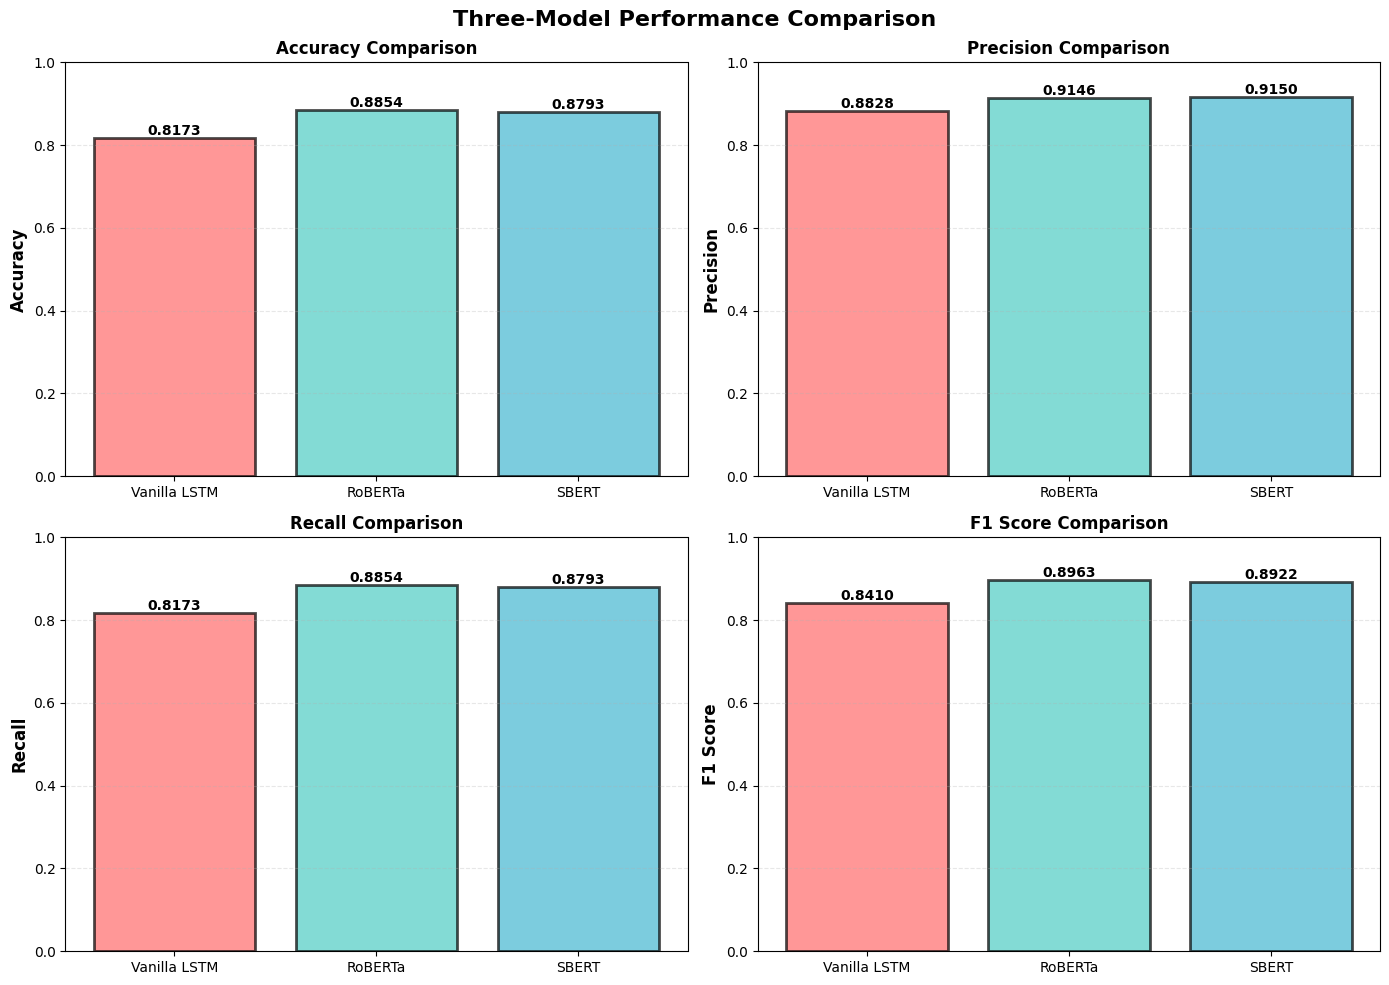

📊 Visualization saved to: outputs/three_model_comparison.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Use the comparison_df that was created earlier
models = comparison_df['Model'].values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Three-Model Performance Comparison', fontsize=16, fontweight='bold')

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = comparison_df[metric].values
    bars = ax.bar(models, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/three_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Visualization saved to: outputs/three_model_comparison.png")

📊 Generating confusion matrices...


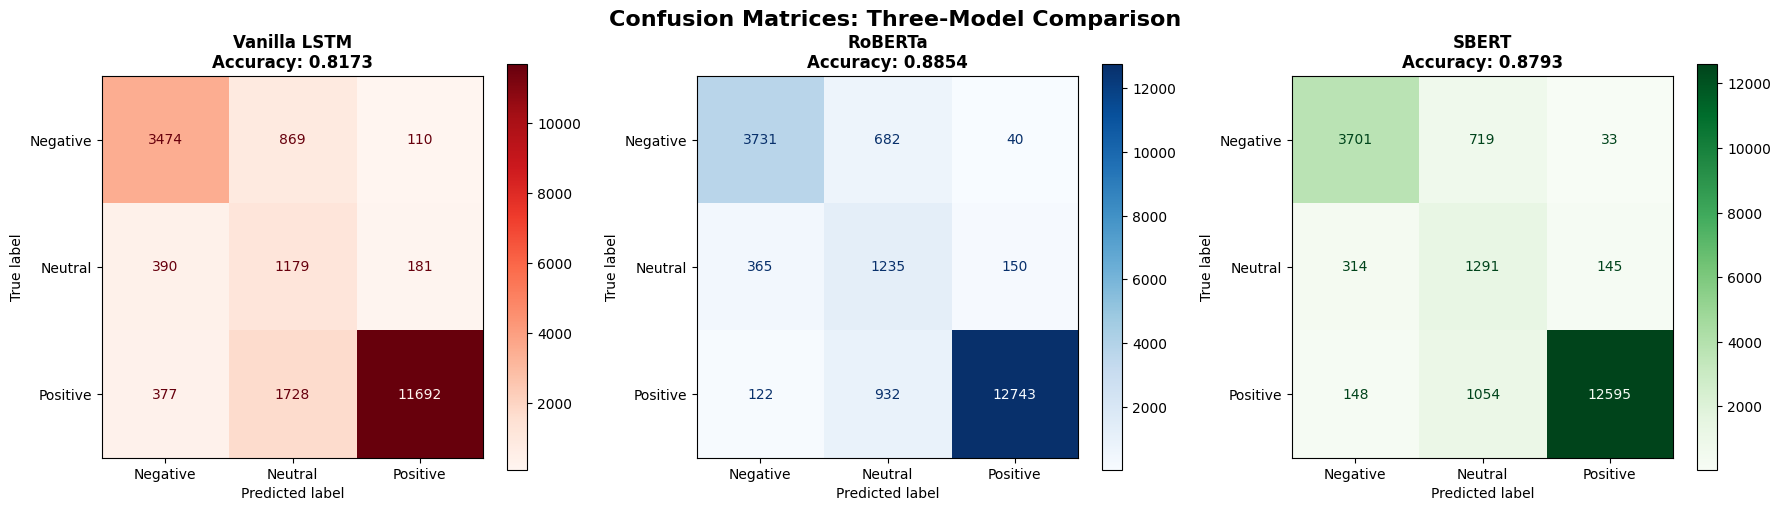

✅ Confusion matrices saved to: outputs/confusion_matrices_comparison.png

📊 NORMALIZED CONFUSION MATRICES (Row Percentages)

Vanilla LSTM:
                Predicted
              Neg     Neu     Pos
Actual Neg   78.01%  19.51%   2.47%
       Neu   22.29%  67.37%  10.34%
       Pos    2.73%  12.52%  84.74%

RoBERTa:
                Predicted
              Neg     Neu     Pos
Actual Neg   83.79%  15.32%   0.90%
       Neu   20.86%  70.57%   8.57%
       Pos    0.88%   6.76%  92.36%

SBERT:
                Predicted
              Neg     Neu     Pos
Actual Neg   83.11%  16.15%   0.74%
       Neu   17.94%  73.77%   8.29%
       Pos    1.07%   7.64%  91.29%


In [ ]:
print("📊 Generating confusion matrices...")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix for Vanilla LSTM
cm_vanilla = confusion_matrix(vanilla_results['labels'], vanilla_results['predictions'])

# Extract confusion matrices for transformer models
cm_roberta = np.array(res_roberta['eval']['metrics']['confusion_matrix'])
cm_sbert = np.array(res_sbert['eval']['metrics']['confusion_matrix'])

# Class names
target_names = ['Negative', 'Neutral', 'Positive']

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices: Three-Model Comparison', fontsize=16, fontweight='bold')

# Vanilla LSTM
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_vanilla, display_labels=target_names)
disp1.plot(cmap='Reds', values_format='d', ax=axes[0])
axes[0].set_title(f'Vanilla LSTM\nAccuracy: {vanilla_results["accuracy"]:.4f}',
                 fontsize=12, fontweight='bold')

# RoBERTa
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_roberta, display_labels=target_names)
disp2.plot(cmap='Blues', values_format='d', ax=axes[1])
axes[1].set_title(f'RoBERTa\nAccuracy: {res_roberta["eval"]["metrics"]["accuracy"]:.4f}',
                 fontsize=12, fontweight='bold')

# SBERT
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm_sbert, display_labels=target_names)
disp3.plot(cmap='Greens', values_format='d', ax=axes[2])
axes[2].set_title(f'SBERT\nAccuracy: {res_sbert["eval"]["metrics"]["accuracy"]:.4f}',
                 fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/confusion_matrices_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Confusion matrices saved to: outputs/confusion_matrices_comparison.png")

# Print normalized confusion matrices (percentages)
print("\n" + "="*70)
print("📊 NORMALIZED CONFUSION MATRICES (Row Percentages)")
print("="*70)

for model_name, cm in [('Vanilla LSTM', cm_vanilla),
                        ('RoBERTa', cm_roberta),
                        ('SBERT', cm_sbert)]:
    print(f"\n{model_name}:")
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    print("                Predicted")
    print("              Neg     Neu     Pos")
    for i, class_name in enumerate(['Actual Neg', '       Neu', '       Pos']):
        print(f"{class_name}  {cm_normalized[i][0]:6.2f}% {cm_normalized[i][1]:6.2f}% {cm_normalized[i][2]:6.2f}%")

---
## SECTION 11: Training History for Vanilla Transformer

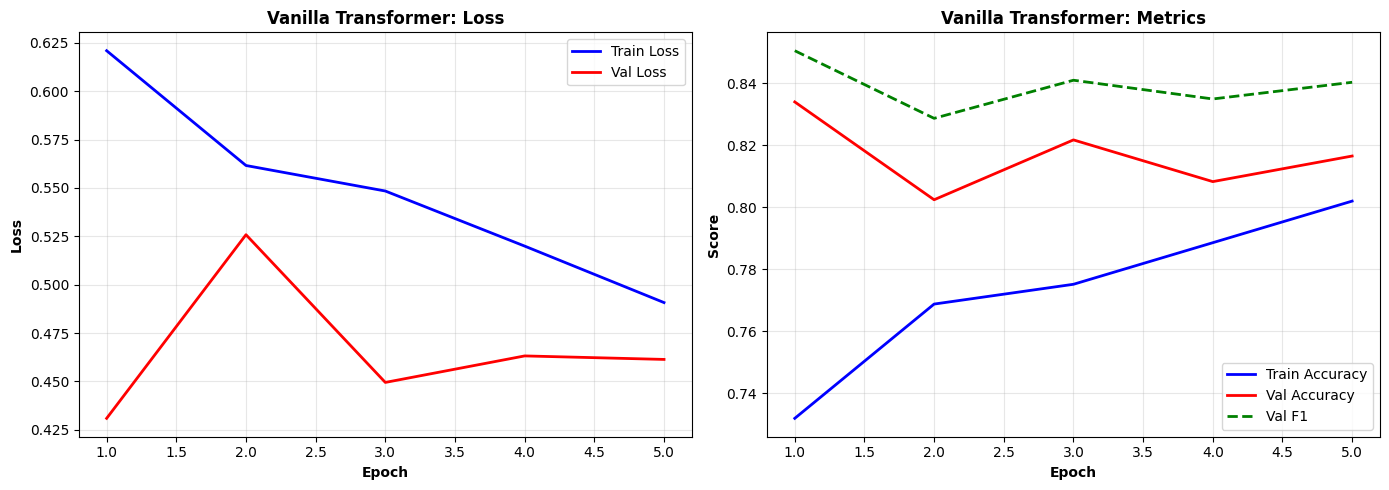

✅ Vanilla Transformer training history saved


In [ ]:
# Plot training history for Vanilla Transformer
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
epochs = range(1, len(vanilla_history['train_loss']) + 1)
axes[0].plot(epochs, vanilla_history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0].plot(epochs, vanilla_history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Loss', fontweight='bold')
axes[0].set_title('Vanilla Transformer: Loss', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(epochs, vanilla_history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
axes[1].plot(epochs, vanilla_history['val_acc'], 'r-', label='Val Accuracy', linewidth=2)
axes[1].plot(epochs, vanilla_history['val_f1'], 'g--', label='Val F1', linewidth=2)
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Score', fontweight='bold')
axes[1].set_title('Vanilla Transformer: Metrics', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/vanilla_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Vanilla Transformer training history saved")

In [ ]:
# Detailed per-class metrics for all models
print("="*70)
print("📊 PER-CLASS PERFORMANCE ANALYSIS")
print("="*70)

target_names = ['Negative', 'Neutral', 'Positive']

# Vanilla Transformer
print("\n🤖 Vanilla Transformer Classification Report:")
print("="*70)
report_vanilla = classification_report(y_true, y_pred_vanilla, target_names=target_names, digits=4)
print(report_vanilla)

# RoBERTa
print("\n🤖 RoBERTa Classification Report:")
print("="*70)
report_roberta = classification_report(y_true, y_pred_roberta, target_names=target_names, digits=4)
print(report_roberta)

# SBERT
print("\n🤖 SBERT Classification Report:")
print("="*70)
report_sbert = classification_report(y_true, y_pred_sbert, target_names=target_names, digits=4)
print(report_sbert)

# Save reports
import json

report_dict_vanilla = classification_report(y_true, y_pred_vanilla, target_names=target_names, output_dict=True)
report_dict_roberta = classification_report(y_true, y_pred_roberta, target_names=target_names, output_dict=True)
report_dict_sbert = classification_report(y_true, y_pred_sbert, target_names=target_names, output_dict=True)

with open('outputs/vanilla_classification_report.json', 'w') as f:
    json.dump(report_dict_vanilla, f, indent=2)

with open(f"{res_roberta['run_outdir']}/classification_report_detailed.json", 'w') as f:
    json.dump(report_dict_roberta, f, indent=2)

with open(f"{res_sbert['run_outdir']}/classification_report_detailed.json", 'w') as f:
    json.dump(report_dict_sbert, f, indent=2)

print("\n✅ Detailed reports saved")

📊 PER-CLASS PERFORMANCE ANALYSIS

🤖 Vanilla Transformer Classification Report:
              precision    recall  f1-score   support

    Negative     0.8191    0.7801    0.7992      4453
     Neutral     0.3122    0.6737    0.4267      1750
    Positive     0.9757    0.8474    0.9071     13797

    accuracy                         0.8173     20000
   macro avg     0.7024    0.7671    0.7110     20000
weighted avg     0.8828    0.8173    0.8410     20000


🤖 RoBERTa Classification Report:
              precision    recall  f1-score   support

    Negative     0.8845    0.8379    0.8606      4453
     Neutral     0.4335    0.7057    0.5371      1750
    Positive     0.9853    0.9236    0.9535     13797

    accuracy                         0.8854     20000
   macro avg     0.7678    0.8224    0.7837     20000
weighted avg     0.9146    0.8854    0.8963     20000


🤖 SBERT Classification Report:
              precision    recall  f1-score   support

    Negative     0.8890    0.8311    0

---
## SECTION 13: Final Summary & Recommendations

In [ ]:
print("="*70)
print("🎉 ALL TRAINING & EVALUATION COMPLETE!")
print("="*70)

print("\n📊 FINAL THREE-MODEL COMPARISON:")
print("="*70)
display(comparison_df)

# Determine winners
print("\n" + "="*70)
print("🏆 BEST PERFORMERS BY METRIC")
print("="*70)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
    best_idx = comparison_df[metric].idxmax()
    best_model = comparison_df.loc[best_idx, 'Model']
    best_value = comparison_df.loc[best_idx, metric]
    print(f"  {metric:12s}: {best_model:15s} ({best_value:.4f})")

# Overall winner
print("\n" + "="*70)
print("🥇 OVERALL WINNER")
print("="*70)
avg_scores = comparison_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].mean(axis=1)
winner_idx = avg_scores.idxmax()
winner_model = comparison_df.loc[winner_idx, 'Model']
winner_score = avg_scores[winner_idx]
print(f"  Model: {winner_model}")
print(f"  Average Score: {winner_score:.4f}")

# Training times comparison
print("\n" + "="*70)
print("⏱️  TRAINING TIME COMPARISON")
print("="*70)
print(f"  Vanilla LSTM: {vanilla_results['training_time']:.2f} minutes")
print(f"  RoBERTa:      {res_roberta['train_seconds']/60:.2f} minutes")
print(f"  SBERT:        {res_sbert['train_seconds']/60:.2f} minutes")

print("\n" + "="*70)
print("✅ All results saved to outputs/ directory")
print("="*70)
print("\nGenerated files:")
print("  - outputs/three_model_comparison.png")
print("  - outputs/per_class_comparison.png")
print("  - outputs/confusion_matrices_comparison.png")
print("  - outputs/team_comparison_results.csv")

🎉 ALL TRAINING & EVALUATION COMPLETE!

📊 FINAL THREE-MODEL COMPARISON:


,Model,Accuracy,Precision,Recall,F1 Score
0,Vanilla LSTM,0.81725,0.882801,0.81725,0.841008
1,RoBERTa,0.88545,0.914589,0.88545,0.896345
2,SBERT,0.87935,0.915045,0.87935,0.892230



🏆 BEST PERFORMERS BY METRIC
  Accuracy    : RoBERTa         (0.8854)
  Precision   : SBERT           (0.9150)
  Recall      : RoBERTa         (0.8854)
  F1 Score    : RoBERTa         (0.8963)

🥇 OVERALL WINNER
  Model: RoBERTa
  Average Score: 0.8955

⏱️  TRAINING TIME COMPARISON
  Vanilla LSTM: 2956.85 minutes
  RoBERTa:      159.13 minutes
  SBERT:        45.56 minutes

✅ All results saved to outputs/ directory

Generated files:
  - outputs/three_model_comparison.png
  - outputs/per_class_comparison.png
  - outputs/confusion_matrices_comparison.png
  - outputs/team_comparison_results.csv


In [ ]:
# Check which model results exist in memory
print("Checking for model results...\n")

variables_to_check = ['vanilla_results', 'res_roberta', 'res_sbert']
available = {}

for var in variables_to_check:
    if var in dir():
        print(f"✅ {var} exists")
        available[var] = True
    else:
        print(f"❌ {var} NOT FOUND")
        available[var] = False

print("\n" + "="*70)
if available['res_roberta']:
    print("RoBERTa results available:")
    print(f"  Accuracy: {res_roberta['eval']['metrics']['accuracy']:.4f}")
    print(f"  F1 Score: {res_roberta['eval']['metrics']['f1']:.4f}")

if available['res_sbert']:
    print("\nSBERT results available:")
    print(f"  Accuracy: {res_sbert['eval']['metrics']['accuracy']:.4f}")
    print(f"  F1 Score: {res_sbert['eval']['metrics']['f1']:.4f}")

Checking for model results...

❌ vanilla_results NOT FOUND
❌ res_roberta NOT FOUND
❌ res_sbert NOT FOUND



In [ ]:
import os

# ============================================================
# EXAMINE REPOSITORY CONTENTS
# ============================================================

repo_path = '/content/dl-project/DL_Team_Project_Code_Files_Structure'

print("="*70)
print("📂 EXAMINING REPOSITORY FILES")
print("="*70)

# 1. Check README
readme_path = '/content/dl-project/README.md'
if os.path.exists(readme_path):
    print("\n📄 README.md:")
    print("-" * 70)
    with open(readme_path, 'r') as f:
        content = f.read()
        print(content[:1000])  # First 1000 chars
        if len(content) > 1000:
            print(f"\n... (truncated, total {len(content)} characters)")

# 2. Examine common_data_prep.py
data_prep_path = f'{repo_path}/src/common_data_prep.py'
if os.path.exists(data_prep_path):
    print("\n" + "="*70)
    print("📄 src/common_data_prep.py:")
    print("-" * 70)
    with open(data_prep_path, 'r') as f:
        content = f.read()
        print(f"Lines: {len(content.splitlines())}")
        print(f"Size: {len(content)} characters")
        print("\nFirst 50 lines:")
        print('\n'.join(content.splitlines()[:50]))

# 3. Examine utils.py
utils_path = f'{repo_path}/src/utils.py'
if os.path.exists(utils_path):
    print("\n" + "="*70)
    print("📄 src/utils.py:")
    print("-" * 70)
    with open(utils_path, 'r') as f:
        content = f.read()
        print(f"Lines: {len(content.splitlines())}")
        print(f"Size: {len(content)} characters")
        print("\nFirst 50 lines:")
        print('\n'.join(content.splitlines()[:50]))

# 4. Examine model.py
model_path = f'{repo_path}/src/model.py'
if os.path.exists(model_path):
    print("\n" + "="*70)
    print("📄 src/model.py:")
    print("-" * 70)
    with open(model_path, 'r') as f:
        content = f.read()
        print(f"Lines: {len(content.splitlines())}")
        print(f"Size: {len(content)} characters")
        print("\nFirst 50 lines:")
        print('\n'.join(content.splitlines()[:50]))

# 5. Check notebook
notebook_path = f'{repo_path}/20251126_22.47_KP_DL_Project_ColabNotebook.ipynb'
if os.path.exists(notebook_path):
    print("\n" + "="*70)
    print("📓 Existing Notebook Found:")
    print("-" * 70)
    import json
    with open(notebook_path, 'r') as f:
        nb = json.load(f)
        print(f"Number of cells: {len(nb['cells'])}")
        print(f"Notebook format: {nb.get('nbformat', 'unknown')}")

📂 EXAMINING REPOSITORY FILES

📄 README.md:
----------------------------------------------------------------------
# dl-project
Deep Learning Project Repo

READ ME
Hi team, Kartek Pallerla (KP) here.!!

Duplicate the .ipynb (Notebook) File named **20251126_22.47_KP_DL_Project_ColabNotebook** to create your own notebook file.
Rename the duplicated notebook (ideas or best tips for renaming: Use time stamp and your initials of your name followed by file name. For example: My notebook is called **20251126 22.47 KP DL Project Colab Notebook**)
Use this notebook that you renamed to conduct your project activities (like loading pre-processed data, coding, model/algorithm setup, training, testing, evaluating, etc).
The detailed instructions are within the notebook (.ipynb) file itself. Please check it out.

Thanks Team!


📄 src/common_data_prep.py:
----------------------------------------------------------------------
Lines: 409
Size: 18084 characters

First 50 lines:
# src/common_data_prep.py
